In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import matplotlib.animation as animation

np.random.seed(1)

# Density & Sampling Parameters
Assumes all uniform densities.

In [3]:
rho_lower = 0.1
rho_upper = 100

sigma_obs_lower = 1/50
sigma_obs_upper = 1/50 + 1/10

N = 1e6

abc_tol = 0.001


# Initialize & sample the densities

In [4]:
# Define densities
rho_delta = rho_upper - rho_lower
sigma_obs_delta = sigma_obs_upper - sigma_obs_lower
sigma_obs_mean = sigma_obs_lower + sigma_obs_delta/2

sigma_obs = st.uniform(sigma_obs_lower, sigma_obs_delta)
prior = st.uniform(rho_lower, rho_delta)
error = st.uniform(-sigma_obs_delta/2, sigma_obs_delta)

# Sample 
N = int(N)
rho_prior_samples = prior.rvs(N)
eps_samples = error.rvs(N)
sigma_obs_samples = sigma_obs.rvs(N)



# Forward Modeling & Density Estimation
Jacobian is $1/\rho^2$, or $1/\sigma^2$

In [5]:
# Forward modeling
sigma_prior_samples = 1/rho_prior_samples + eps_samples

In [6]:
# Density estimation
rho = np.logspace(np.log10(rho_lower)-0.15, np.log10(rho_upper)+0.15, 1000)
sigma = 1/rho

f_rho = prior.pdf(rho)
f_sigma = prior.pdf(rho) / sigma**2 #with Jacobian
f_obs = sigma_obs.pdf(sigma)

# Posterior Estimation

In [7]:
# ABC
post_abc = rho_prior_samples[np.abs(sigma_prior_samples-sigma_obs_mean) < abc_tol]
print('Number of ABC samples: {}'.format(post_abc.shape[0]))

# Likelihood-driven posterior
post_lkl = sigma_obs.pdf(sigma) * f_rho  / np.trapz(sigma_obs.pdf(sigma) * f_rho, x=rho)

# MT posterior
post_measure = f_rho / f_sigma * f_obs

# Tarantola
post_tarantola = post_lkl * sigma / np.trapz(post_lkl * sigma, x=rho)


Number of ABC samples: 8392


<ipython-input-7-281afccd8c02>:9: RuntimeWarning: invalid value encountered in true_divide
  post_measure = f_rho / f_sigma * f_obs


# Pushing Forward Posteriors

In [8]:
# ABC
post_abc_push = 1/post_abc

# Likelihood
post_lkl_push = post_lkl / sigma**2

# MT 
post_measure_push = post_measure / sigma**2

# Tarantola
post_tarantola_push = post_tarantola / sigma**2

# Plot

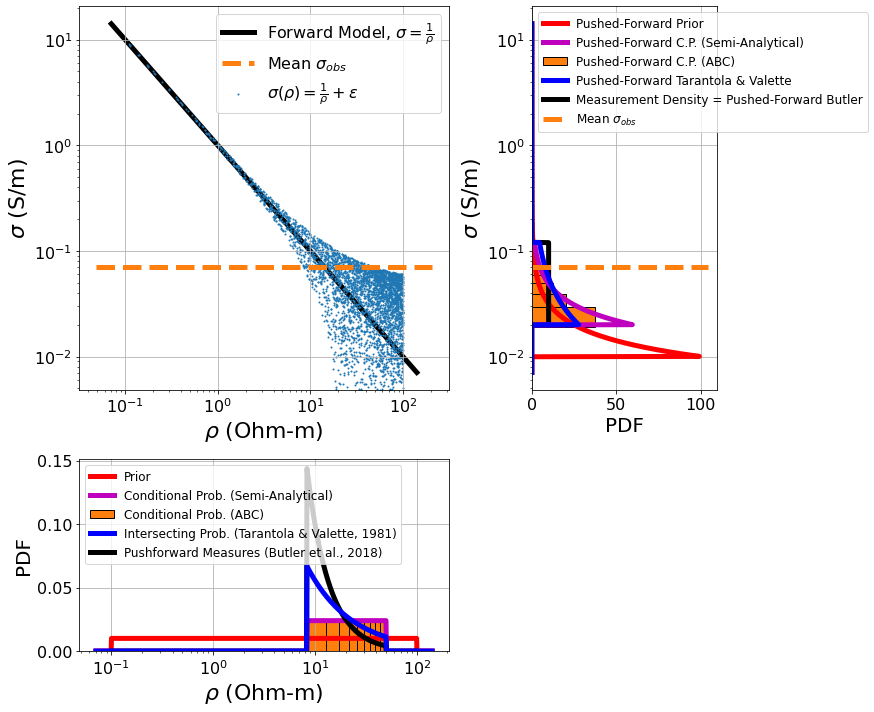

In [22]:

fig, axs = plt.subplots(2,2, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1], 'width_ratios':[2,1]})

axs[0,0].plot(rho, sigma, '-k', linewidth=5, label=r'Forward Model, $\sigma=\frac{1}{\rho}$', zorder=0)
axs[0,0].scatter(rho_prior_samples[:5000], sigma_prior_samples[:5000], 1, label=r'$\sigma(\rho)=\frac{1}{\rho} + \varepsilon$',zorder=1)
axs[0,0].set_yscale('log')
axs[0,0].set_xscale('log')
axs[0,0].tick_params(labelsize=16)
axs[0,0].set_ylabel(r'$\sigma$ (S/m)', fontsize=22)
axs[0,0].set_xlabel(r'$\rho$ (Ohm-m)', fontsize=22)
axs[0,0].grid()
xl = axs[0,0].get_xlim()
axs[0,0].plot(xl, [sigma_obs_mean,sigma_obs_mean], '--', color='C1', linewidth=5, label=r'Mean $\sigma_{obs}$', zorder=2)
axs[0,0].legend(fontsize=16)

# axs[0,0].text(100,10, '(a)')

axs[1,0].plot(rho, f_rho, '-r', linewidth=5, label=r'Prior')
axs[1,0].plot(rho, post_lkl, '-m', linewidth=5,  label=r'Conditional Prob. (Semi-Analytical)')
axs[1,0].plot(rho, post_measure, '-k', linewidth=5,  label=r'Pushforward Measures (Butler et al., 2018)')
axs[1,0].plot(rho, post_tarantola, '-b', linewidth=5, label=r'Intersecting Prob. (Tarantola & Valette, 1981)')
axs[1,0].hist(post_abc, density=True, label='Conditional Prob. (ABC)', facecolor='C1', edgecolor='k')
axs[1,0].set_xscale('log')
axs[1,0].tick_params(labelsize=16)
axs[1,0].set_ylabel('PDF', fontsize=20)
axs[1,0].set_xlabel(r'$\rho$ (Ohm-m)', fontsize=22)
axs[1,0].grid()
ylb = axs[1,0].get_ylim()
handles, labels = axs[1,0].get_legend_handles_labels()
order = [0,1,4,3,2]
axs[1,0].legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize=12, loc='upper left')


axs[0,1].plot(f_sigma, sigma, '-r', linewidth=5, label=r'Pushed-Forward Prior')
axs[0,1].plot(f_obs, sigma, '-k', linewidth=5, label=r'Measurement Density = Pushed-Forward Butler')
axs[0,1].plot(post_lkl_push, sigma, '-m', linewidth=5, label=r'Pushed-Forward C.P. (Semi-Analytical)')
axs[0,1].hist(post_abc_push, density=True, facecolor='C1', edgecolor='k', orientation='horizontal', label='Pushed-Forward C.P. (ABC)')
axs[0,1].plot(post_tarantola_push, sigma, '-b', linewidth=5, label=r'Pushed-Forward Tarantola & Valette')
axs[0,1].set_yscale('log')
axs[0,1].tick_params(labelsize=16)
axs[0,1].set_xlabel('PDF', fontsize=20)
axs[0,1].set_ylabel(r'$\sigma$ (S/m)', fontsize=22)
axs[0,1].grid()
xlr = axs[0,1].get_xlim()
axs[0,1].plot(xlr, [sigma_obs_mean,sigma_obs_mean], '--',color='C1',linewidth=5, label=r'Mean $\sigma_{obs}$')
handles, labels = axs[0,1].get_legend_handles_labels()
order = [0,2,5,3,1,4]
axs[0,1].legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize=12)

axs[1,1].axis('off')
fig.tight_layout()

In [13]:
handles

[]